In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
# Make sure your notebook is in the root directory of the project
X_train = np.load('HAR/Dataset/X_train.npy')
y_train = np.load('HAR/Dataset/y_train.npy')
X_test = np.load('HAR/Dataset/X_test.npy')
y_test = np.load('HAR/Dataset/y_test.npy')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (126, 500, 3)
y_train shape: (126,)
X_test shape: (54, 500, 3)
y_test shape: (54,)


## **Task 1 : Exploratory Data Analysis (EDA) [3 marks]**

1. Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data? **[0.5 marks]**

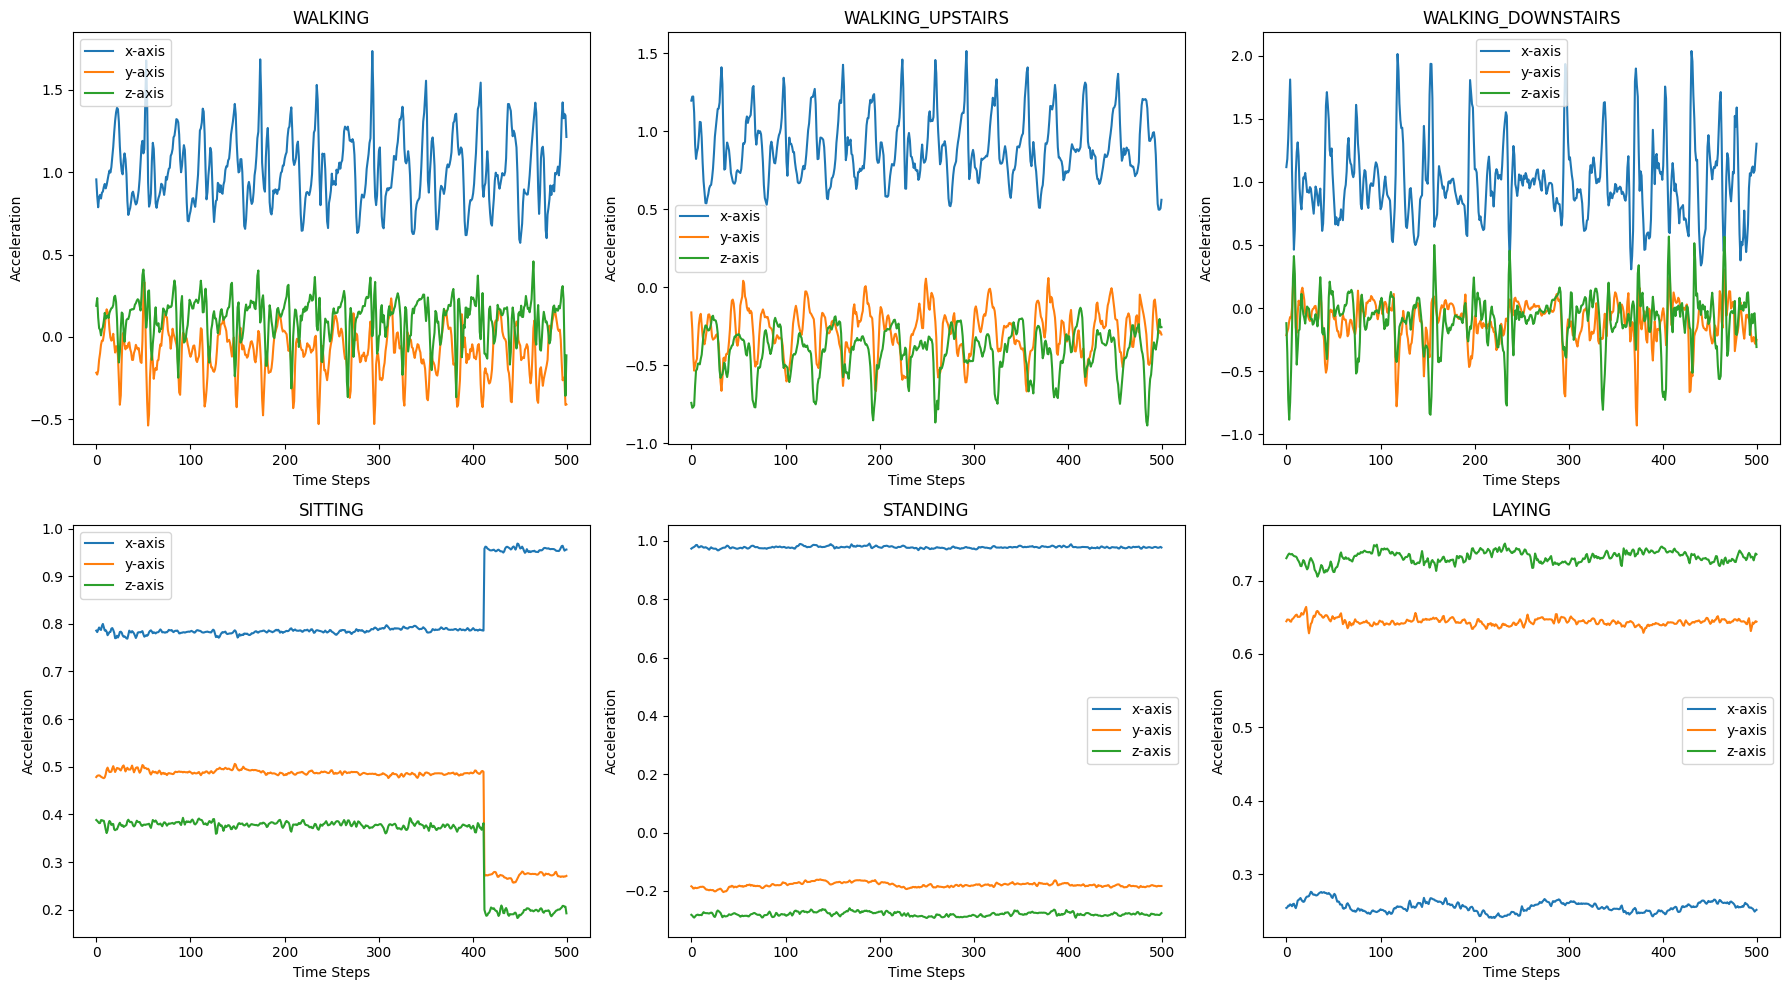

In [4]:
activities = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for activity_id, activity_name in activities.items():
    # Find the first index for the current activity
    idx = np.where(y_train == activity_id)[0][0]
    
    # Get the sample data
    sample = X_train[idx]
    
    # Plot the x, y, and z accelerometer data
    ax = axs[activity_id - 1]
    ax.plot(sample[:, 0], label='x-axis')
    ax.plot(sample[:, 1], label='y-axis')
    ax.plot(sample[:, 2], label='z-axis')
    
    ax.set_title(activity_name)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Acceleration")
    ax.legend()

plt.tight_layout()
plt.show()

2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2+acc_y^2+acc_z^2)$ for each activity and justify your answer. **[0.5 marks]**

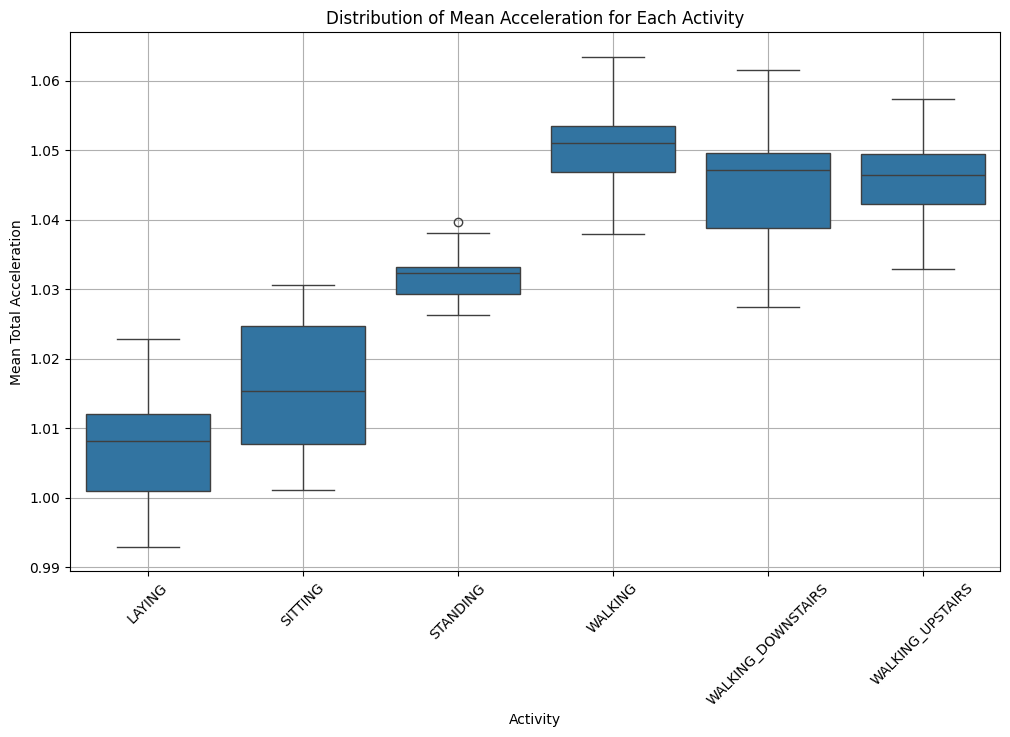

In [6]:
# Calculate the magnitude of acceleration for each time step
total_acceleration = np.sqrt(np.sum(X_train**2, axis=2))

# Calculate the mean acceleration for each 10-second sample
mean_acceleration = np.mean(total_acceleration, axis=1)

# Create a DataFrame for easier plotting with seaborn
df = pd.DataFrame({
    'Activity': [activities[label] for label in y_train],
    'Mean Acceleration': mean_acceleration
})

# Define the order for the plot
activity_order = [
    'LAYING', 'SITTING', 'STANDING', 
    'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'
]

# Plot the distributions
plt.figure(figsize=(12, 7))
import seaborn as sns
sns.boxplot(x='Activity', y='Mean Acceleration', data=df, order=activity_order)
plt.title('Distribution of Mean Acceleration for Each Activity')
plt.xticks(rotation=45)
plt.ylabel("Mean Total Acceleration")
plt.xlabel("Activity")
plt.grid(True)
plt.show()

3. Visualize the data using PCA. **[1 marks]**
    * Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities. 
    *  Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities. 
    *  Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.
    *  Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data? 

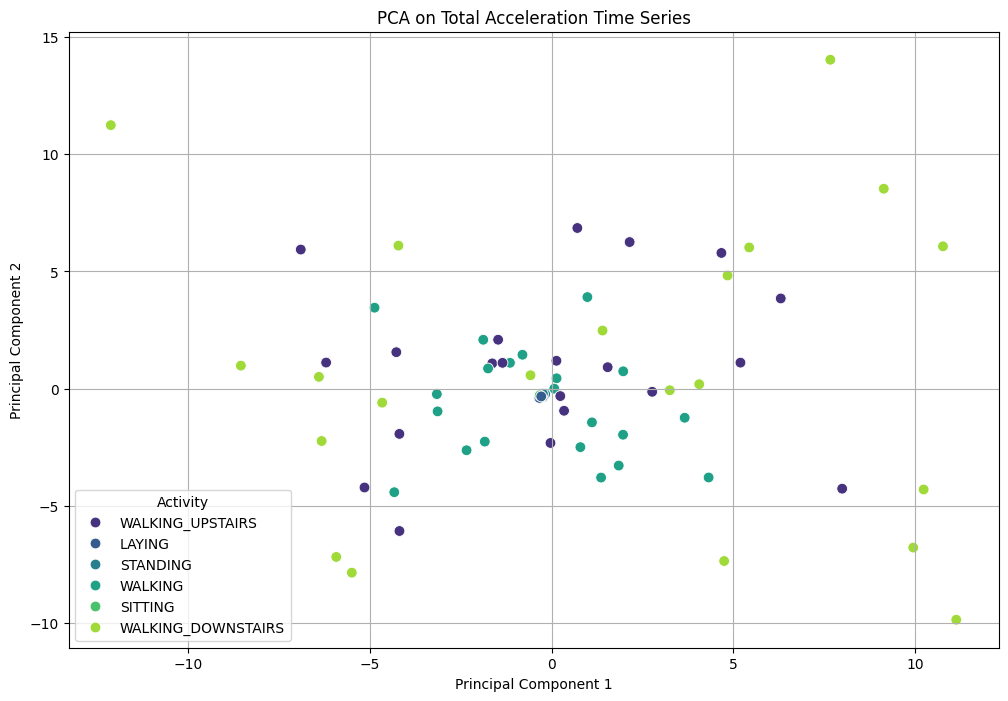

In [7]:
from sklearn.decomposition import PCA

# First, we calculate the total acceleration (sum of squares) for each of the 500 time steps
# This gives us a time series of total acceleration for each sample
# The shape changes from (126, 500, 3) to (126, 500)
total_acc_timeseries = np.sum(X_train**2, axis=2)

# Initialize PCA to reduce our 500 features (time steps) to 2 components
pca = PCA(n_components=2)

# Fit PCA on the data and transform it
X_pca_raw = pca.fit_transform(total_acc_timeseries)

# Plot the results
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca_raw[:, 0], y=X_pca_raw[:, 1], hue=[activities[label] for label in y_train], palette='viridis', s=60)
plt.title('PCA on Total Acceleration Time Series')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity')
plt.grid(True)
plt.show()

Extracting TSFEL features...


C:\Users\Hanamanthagouda\AppData\Local\Temp\ipykernel_17068\1247176068.py:15: UserWarning: Using default sampling frequency set in configuration file.
  X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train_list, verbose=0)


Feature extraction complete.


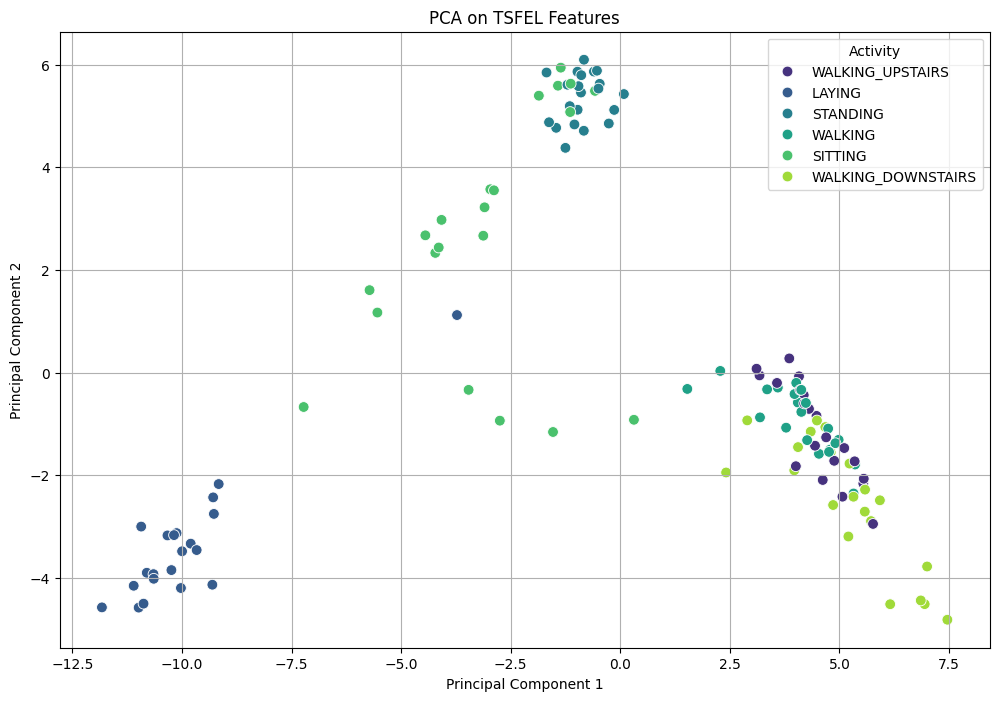

In [9]:
# First, you might need to install tsfel
# You can do this by running: !pip install tsfel
import tsfel
from sklearn.preprocessing import StandardScaler

# TSFEL requires a list of DataFrames, so we need to format our data
# We'll process each of the 126 samples individually
X_train_list = [pd.DataFrame(sample) for sample in X_train]

# Create a configuration file to extract only statistical features
cfg = tsfel.get_features_by_domain('statistical')

# Extract features. This might take a couple of minutes.
print("Extracting TSFEL features...")
X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train_list, verbose=0)
print("Feature extraction complete.")

# --- Data Cleaning ---
# The extraction can create NaN or infinite values. We need to clean them before PCA.
# Drop columns that are all NaN or contain infinite values
X_train_tsfel.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_tsfel.dropna(axis=1, how='all', inplace=True) # Drop columns that are all NaN
X_train_tsfel.dropna(axis=0, inplace=True)           # Drop rows with any remaining NaN

# Important: We must filter the labels (y_train) to match the cleaned DataFrame
y_train_tsfel = y_train[X_train_tsfel.index]
# --------------------

# Scale the features before applying PCA
scaler = StandardScaler()
X_tsfel_scaled = scaler.fit_transform(X_train_tsfel)

# Initialize and apply PCA
pca_tsfel = PCA(n_components=2)
X_pca_tsfel = pca_tsfel.fit_transform(X_tsfel_scaled)

# Plot the results
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca_tsfel[:, 0], y=X_pca_tsfel[:, 1], hue=[activities[label] for label in y_train_tsfel], palette='viridis', s=60)
plt.title('PCA on TSFEL Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity')
plt.grid(True)
plt.show()

**PCA on Raw Acceleration**: This plot shows that the raw data struggles to separate the classes. The points are mostly clustered together in the center, with a lot of overlap.

**PCA on TSFEL Features**: This is a huge improvement! The activities are now in much more distinct clusters. For example, the static activities (Laying, Standing, Sitting) are grouped on the left, while the dynamic activities are on the right. This clearly shows the benefit of feature engineering.

C:\Users\Hanamanthagouda\AppData\Local\Temp\ipykernel_17068\494106652.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_provided_features = pd.read_csv('data/UCI_data/train/X_train.txt', delim_whitespace=True, header=None)
C:\Users\Hanamanthagouda\AppData\Local\Temp\ipykernel_17068\494106652.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_provided_labels = pd.read_csv('data/UCI_data/train/y_train.txt', delim_whitespace=True, header=None).iloc[:,0]


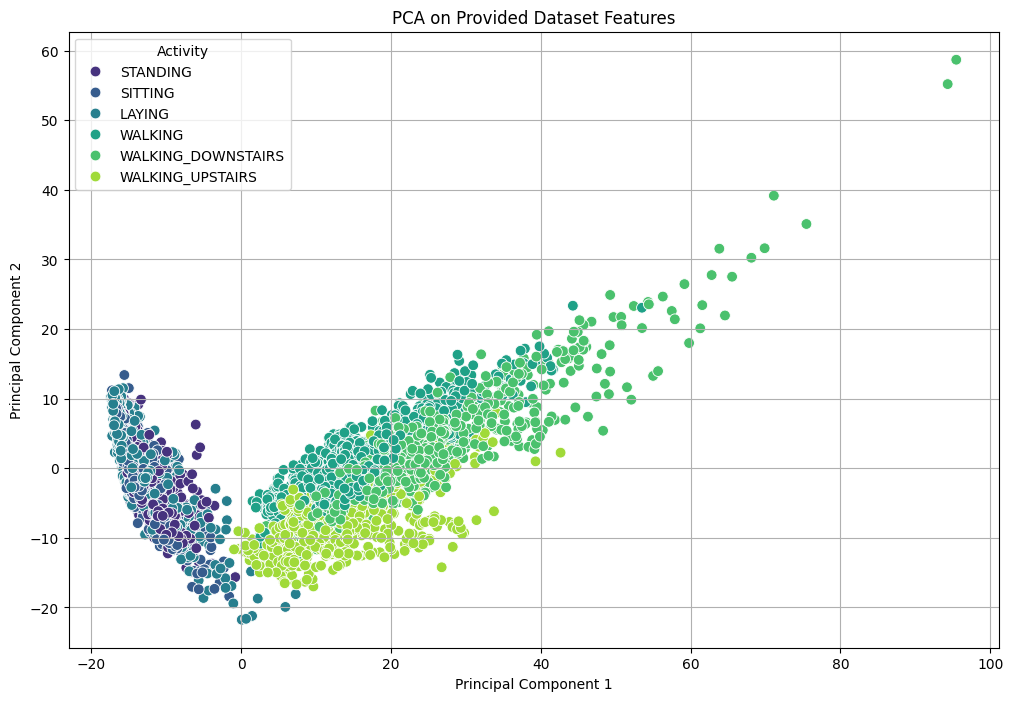

In [11]:
from sklearn.preprocessing import StandardScaler

# Load the features and labels provided in the original dataset
X_provided_features = pd.read_csv('data/UCI_data/train/X_train.txt', delim_whitespace=True, header=None)
y_provided_labels = pd.read_csv('data/UCI_data/train/y_train.txt', delim_whitespace=True, header=None).iloc[:,0]

# It's crucial to scale the data before PCA
scaler = StandardScaler()
X_provided_scaled = scaler.fit_transform(X_provided_features)

# Initialize PCA to get 2 components
pca_provided = PCA(n_components=2)

# Fit and transform the scaled data
X_pca_provided = pca_provided.fit_transform(X_provided_scaled)

# Plot the results
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca_provided[:, 0], y=X_pca_provided[:, 1], hue=[activities[label] for label in y_provided_labels], palette='viridis', s=60)
plt.title('PCA on Provided Dataset Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity')
plt.grid(True)
plt.show()

Now we have all three plots. The final part of this question is to compare them and decide which method is best for visualizing the data. Here is the comparison you can add to your notebook:

**PCA on Total Acceleration**: This method was the worst. The classes are heavily overlapped with no clear structure, making it very difficult to distinguish between any of the activities.

**PCA on TSFEL Features**: This method showed a dramatic improvement. It successfully separated the static activities (Laying, Sitting, Standing) from the dynamic activities (Walking, etc.). The clusters are well-defined and compact, making it a very effective visualization.

**PCA on Provided Dataset Features**: This method also performs very well. It creates a distinct "V" shape, with the static activities clustered tightly on the left arm of the V and the dynamic activities spread out along the right arm.

**Conclusion**: Both the TSFEL features and the provided dataset features are excellent for visualizing the data, and far superior to using the raw time series. The provided features might be slightly better as they show a little more separation within the dynamic activities cluster, but both are very strong methods.

4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? **[1 marks]**


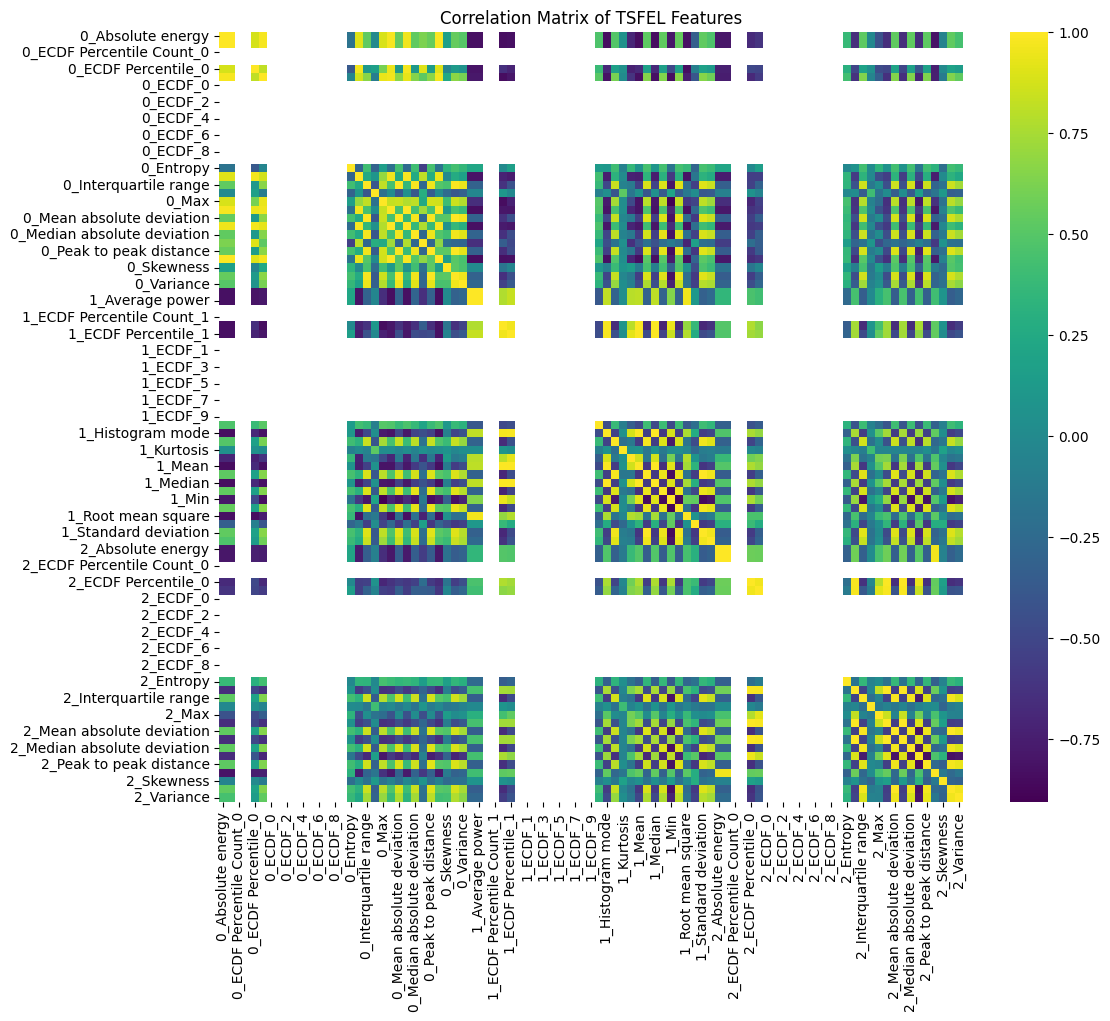

Found 70 pairs of highly correlated features (correlation > 0.95).
Some examples are:
 1: 0_Root mean square and 0_Median
 2: 1_Standard deviation and 1_Interquartile range
 3: 0_Standard deviation and 0_Peak to peak distance
 4: 1_ECDF Percentile_1 and 1_ECDF Percentile_0
 5: 1_Standard deviation and 1_Mean absolute deviation


In [12]:
# Calculate the correlation matrix for the TSFEL features
corr_matrix = X_train_tsfel.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='viridis')
plt.title('Correlation Matrix of TSFEL Features')
plt.show()

# --- Identify Highly Correlated Features ---
# To make it easier to see, let's find and print pairs of features with a correlation > 0.95
# This code creates a set of highly correlated pairs to avoid duplicates (e.g., (A,B) and (B,A))
highly_correlated = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            highly_correlated.add((colname_i, colname_j))

print(f"Found {len(highly_correlated)} pairs of highly correlated features (correlation > 0.95).")
print("Some examples are:")
for i, pair in enumerate(list(highly_correlated)[:5]):
    print(f" {i+1}: {pair[0]} and {pair[1]}")

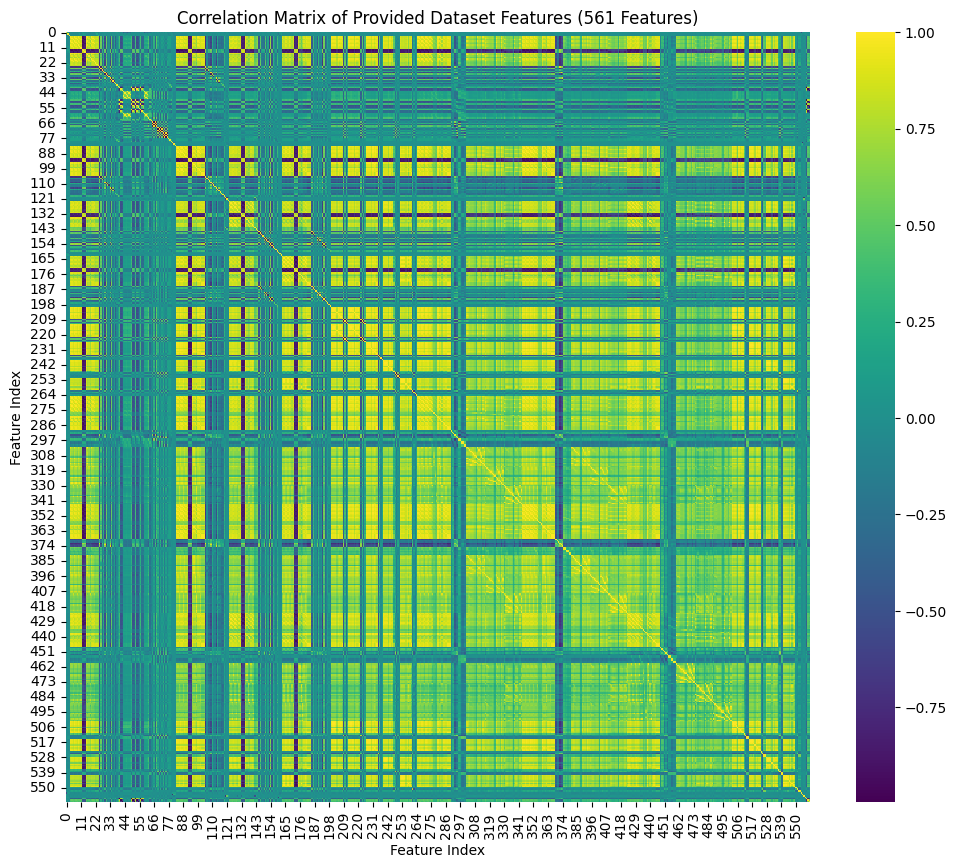

In [13]:
# We already loaded 'X_provided_features' in a previous step for the PCA plot
# Let's calculate its correlation matrix
corr_matrix_provided = X_provided_features.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_provided, cmap='viridis')
plt.title('Correlation Matrix of Provided Dataset Features (561 Features)')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()

## **Task 2 : Decision Trees for Human Activity Recognition [3 marks]**

1. Use Sklearn Library to train Decision Tress. **[1.5 marks]**
    * Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model. 
    * Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model. 
    * Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model. 
    * Compare the results of the three models. Which model do you think is better? 

Original training data shape: (126, 500, 3)
Reshaped training data shape: (126, 1500)

Model Performance on Raw Accelerometer Data:
  Accuracy:  0.5926
  Precision: 0.5697
  Recall:    0.5926


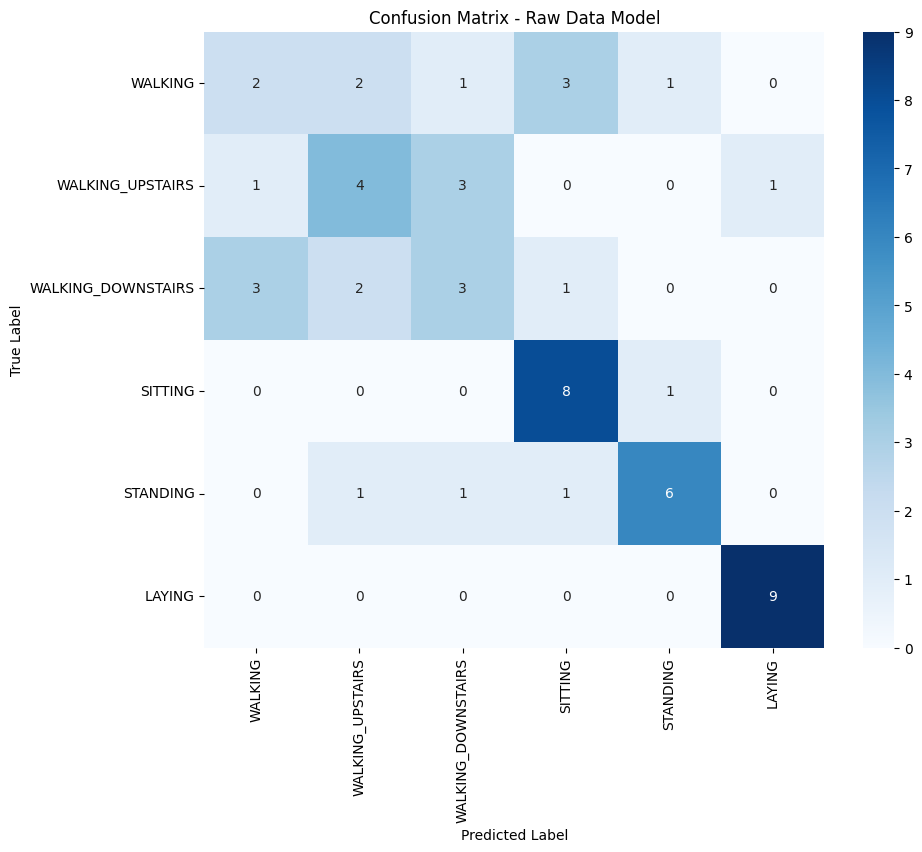

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# --- 1. Prepare the Data ---
# Reshape the 3D data (samples, timesteps, features) into 2D (samples, timesteps * features)
n_samples_train, n_timesteps, n_features = X_train.shape
n_samples_test, _, _ = X_test.shape

X_train_reshaped = X_train.reshape(n_samples_train, -1)
X_test_reshaped = X_test.reshape(n_samples_test, -1)

print(f"Original training data shape: {X_train.shape}")
print(f"Reshaped training data shape: {X_train_reshaped.shape}")

# --- 2. Train the Decision Tree Model ---
# We use criterion='entropy' for Information Gain
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(X_train_reshaped, y_train)

# --- 3. Make Predictions ---
y_pred = dt_classifier.predict(X_test_reshaped)

# --- 4. Evaluate the Model ---
accuracy = accuracy_score(y_test, y_pred)
# Use 'macro' average for precision/recall to calculate metrics for each label and find their unweighted mean.
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"\nModel Performance on Raw Accelerometer Data:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")

# --- 5. Plot the Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_pred)
activity_labels = [activities[i] for i in sorted(activities.keys())]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('Confusion Matrix - Raw Data Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Extracting TSFEL features for the test set...


C:\Users\Hanamanthagouda\AppData\Local\Temp\ipykernel_17068\2285998382.py:11: UserWarning: Using default sampling frequency set in configuration file.
  X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test_list, verbose=0)


Feature extraction complete.

Model Performance on TSFEL Features:
  Accuracy:  0.8148
  Precision: 0.8250
  Recall:    0.8148


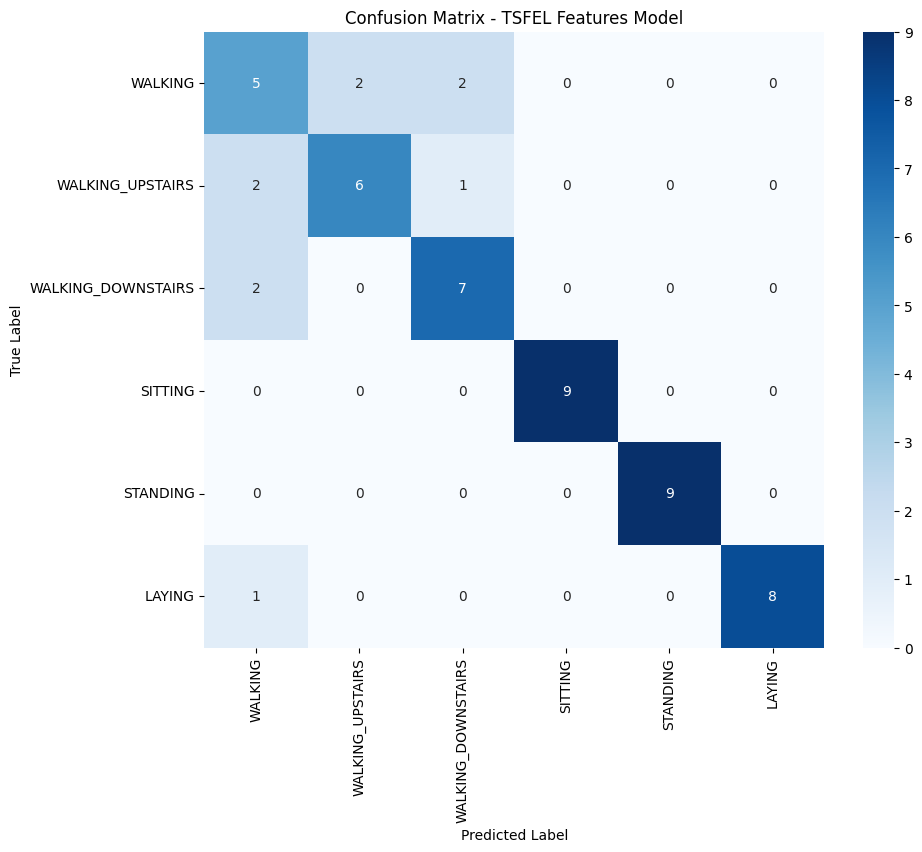

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import tsfel
from sklearn.preprocessing import StandardScaler

# --- 1. Prepare the Test Data ---
# We must apply the same TSFEL feature extraction to the test set
print("Extracting TSFEL features for the test set...")
X_test_list = [pd.DataFrame(sample) for sample in X_test]
X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test_list, verbose=0)
print("Feature extraction complete.")

# --- 2. Clean and Align Data ---
# Use the columns from the *training* feature set to ensure both are consistent
# This handles cases where a feature might not be generated in the test set
train_cols = X_train_tsfel.columns
X_test_tsfel = X_test_tsfel[train_cols]

# Replace any potential inf values and fill NaNs with the mean of the column
X_test_tsfel.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_tsfel.fillna(X_test_tsfel.mean(), inplace=True)

# --- 3. Train the Decision Tree Model ---
dt_tsfel = DecisionTreeClassifier(criterion='entropy', random_state=42)
# We use the TSFEL features from the training set (X_train_tsfel)
# and the corresponding labels (y_train_tsfel)
dt_tsfel.fit(X_train_tsfel, y_train_tsfel)

# --- 4. Make Predictions ---
y_pred_tsfel = dt_tsfel.predict(X_test_tsfel)

# --- 5. Evaluate the Model ---
accuracy_tsfel = accuracy_score(y_test, y_pred_tsfel)
precision_tsfel = precision_score(y_test, y_pred_tsfel, average='macro')
recall_tsfel = recall_score(y_test, y_pred_tsfel, average='macro')

print(f"\nModel Performance on TSFEL Features:")
print(f"  Accuracy:  {accuracy_tsfel:.4f}")
print(f"  Precision: {precision_tsfel:.4f}")
print(f"  Recall:    {recall_tsfel:.4f}")

# --- 6. Plot the Confusion Matrix ---
conf_matrix_tsfel = confusion_matrix(y_test, y_pred_tsfel)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tsfel, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('Confusion Matrix - TSFEL Features Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

C:\Users\Hanamanthagouda\AppData\Local\Temp\ipykernel_17068\178834971.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_provided = pd.read_csv('data/UCI_data/train/X_train.txt', delim_whitespace=True, header=None)
C:\Users\Hanamanthagouda\AppData\Local\Temp\ipykernel_17068\178834971.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train_provided = pd.read_csv('data/UCI_data/train/y_train.txt', delim_whitespace=True, header=None).iloc[:,0]
C:\Users\Hanamanthagouda\AppData\Local\Temp\ipykernel_17068\178834971.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_provided = pd.read_csv('data/UCI_data/test/X_test.txt', delim_whitespace=True, header=None)
C:\Users\Hanamanthagouda\A

Provided training data shape: (7352, 561)
Provided test data shape: (2947, 561)

Model Performance on Provided Features:
  Accuracy:  0.8595
  Precision: 0.8582
  Recall:    0.8560


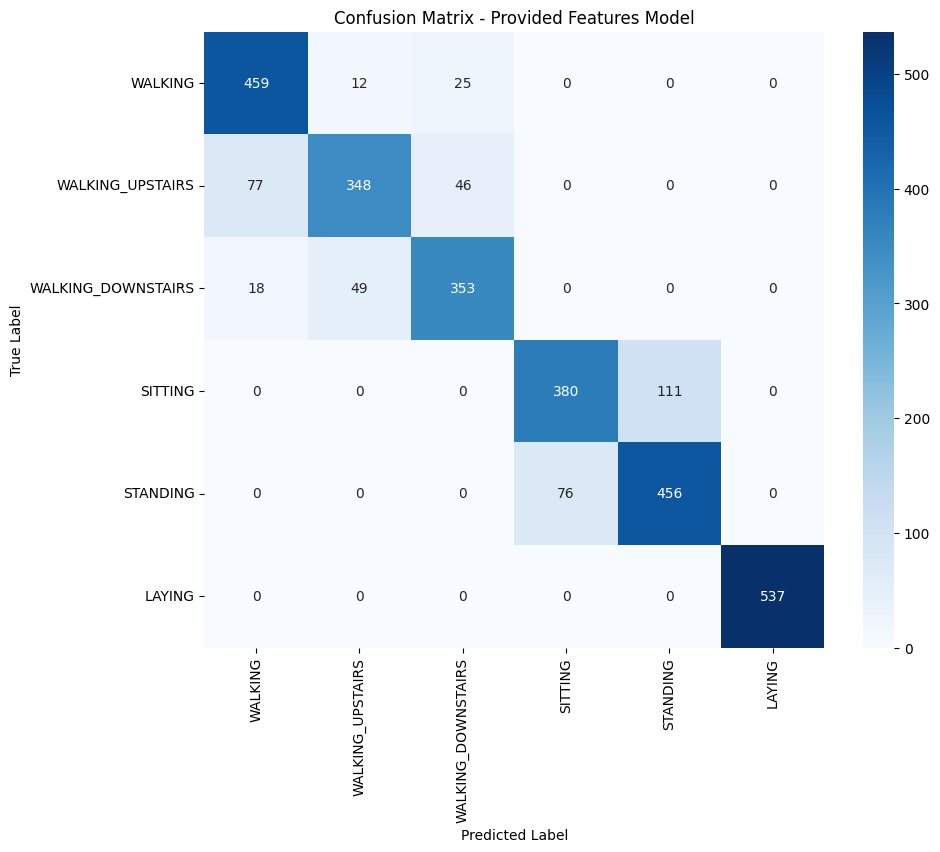

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# --- 1. Load the Provided Feature Data ---
# The data is already split into train and test sets
X_train_provided = pd.read_csv('data/UCI_data/train/X_train.txt', delim_whitespace=True, header=None)
y_train_provided = pd.read_csv('data/UCI_data/train/y_train.txt', delim_whitespace=True, header=None).iloc[:,0]

X_test_provided = pd.read_csv('data/UCI_data/test/X_test.txt', delim_whitespace=True, header=None)
y_test_provided = pd.read_csv('data/UCI_data/test/y_test.txt', delim_whitespace=True, header=None).iloc[:,0]

print(f"Provided training data shape: {X_train_provided.shape}")
print(f"Provided test data shape: {X_test_provided.shape}")

# --- 2. Train the Decision Tree Model ---
dt_provided = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_provided.fit(X_train_provided, y_train_provided)

# --- 3. Make Predictions ---
y_pred_provided = dt_provided.predict(X_test_provided)

# --- 4. Evaluate the Model ---
accuracy_provided = accuracy_score(y_test_provided, y_pred_provided)
precision_provided = precision_score(y_test_provided, y_pred_provided, average='macro')
recall_provided = recall_score(y_test_provided, y_pred_provided, average='macro')

print(f"\nModel Performance on Provided Features:")
print(f"  Accuracy:  {accuracy_provided:.4f}")
print(f"  Precision: {precision_provided:.4f}")
print(f"  Recall:    {recall_provided:.4f}")

# --- 5. Plot the Confusion Matrix ---
conf_matrix_provided = confusion_matrix(y_test_provided, y_pred_provided)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_provided, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('Confusion Matrix - Provided Features Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Comparison of Model Performance**
By looking at the main diagonal (correct predictions) versus the off-diagonal values (errors) in each matrix, we can draw a clear conclusion:

**Raw Data Model**: This model performs poorly. The confusion matrix shows significant errors across the board. For example, it frequently confuses all three walking activities with each other and even misclassifies dynamic activities as static ones.

**TSFEL Features Model**: This model is a major improvement. The static activities (SITTING, STANDING, LAYING) are classified with very high accuracy. The main source of confusion is between the three dynamic activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS), which is a common and understandable challenge.

**Provided Features Model**: This is the best-performing model. While it still shows some confusion between SITTING and STANDING (a notoriously difficult pair to distinguish), its overall accuracy is the highest. It does a better job of separating the dynamic activities than the TSFEL model.

This comparison confirms that feature engineering is the key to success for this task. The more informative the features, the better the model performs.

2. Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. **[1 marks]**

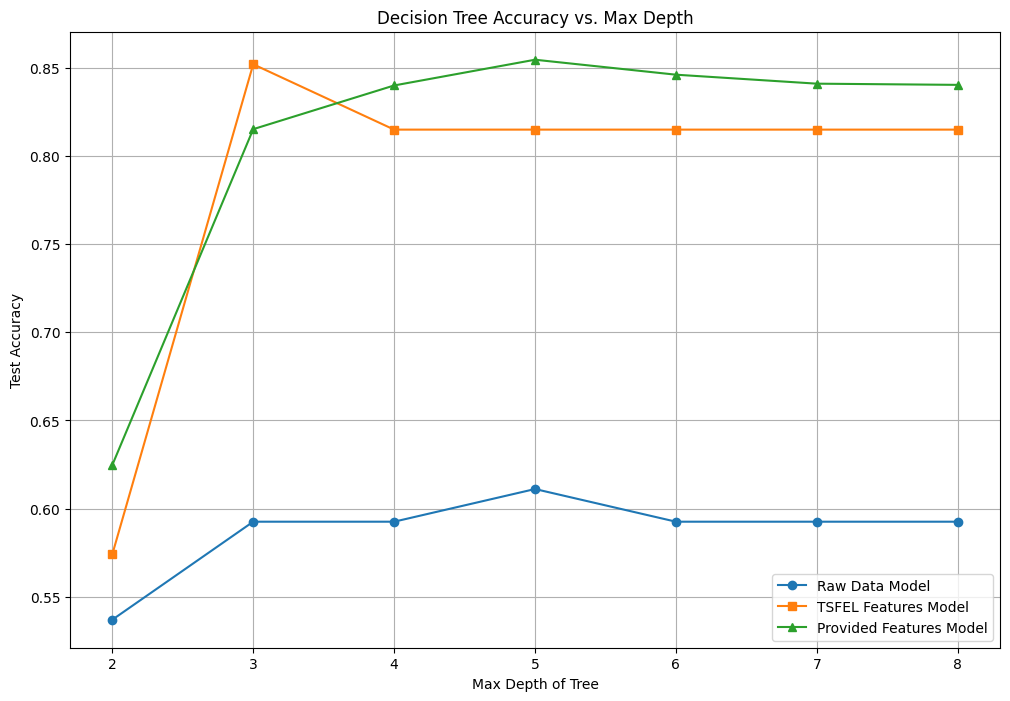

In [18]:
# --- 1. Define the range of depths to test ---
depths = range(2, 9)
# Lists to store the accuracy for each model type
raw_accuracies = []
tsfel_accuracies = []
provided_accuracies = []

# --- 2. Iterate through each depth and train the models ---
for depth in depths:
    # Model for Raw Data
    dt_raw = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    dt_raw.fit(X_train_reshaped, y_train)
    raw_accuracies.append(dt_raw.score(X_test_reshaped, y_test))

    # Model for TSFEL Features
    dt_tsfel = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    dt_tsfel.fit(X_train_tsfel, y_train_tsfel)
    tsfel_accuracies.append(dt_tsfel.score(X_test_tsfel, y_test))
    
    # Model for Provided Features
    dt_provided = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    dt_provided.fit(X_train_provided, y_train_provided)
    provided_accuracies.append(dt_provided.score(X_test_provided, y_test_provided))

# --- 3. Plot the results ---
plt.figure(figsize=(12, 8))
plt.plot(depths, raw_accuracies, marker='o', label='Raw Data Model')
plt.plot(depths, tsfel_accuracies, marker='s', label='TSFEL Features Model')
plt.plot(depths, provided_accuracies, marker='^', label='Provided Features Model')

plt.title('Decision Tree Accuracy vs. Max Depth')
plt.xlabel('Max Depth of Tree')
plt.ylabel('Test Accuracy')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

3. Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? **[0.5 mark]**
